In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
predictions_df = pd.read_csv("predictions_mnist.csv")
display(predictions_df.head())

,groundtruth,knn,knn_pca,lr,lr_pca,rf,rf_pca
0,7,7,7,7,7,7,7
1,2,2,2,2,2,2,2
2,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0
4,4,4,4,4,4,4,4


In [3]:
# Sort rows for visualization purpose
predictions_df = predictions_df.sort_values(by=["groundtruth"])
display(predictions_df.head())

,groundtruth,knn,knn_pca,lr,lr_pca,rf,rf_pca
4999,0,0,0,0,0,0,0
7747,0,0,0,0,0,0,0
1297,0,0,0,0,0,0,0
9311,0,0,0,0,0,0,0
1294,0,0,0,0,0,0,0


In [4]:
models_name = list(predictions_df.columns)
models_name.remove("groundtruth")

# Models metrics
We compute accuracy, precision, recall and F1 score for each model. We compute also F1 score global.

Accuracy score is equal to recall score because the number of elements is equal for each category in the training set (1000 per category).

In [5]:
metrics_df = dict()
for m in models_name:
    # Compute metrics for each model
    y_true = predictions_df["groundtruth"]
    y_pred = predictions_df[m]
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred, average="macro")
    recall = recall_score(y_true=y_true, y_pred=y_pred, average="macro")
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average="macro")
    f1_glob = (2 * precision * recall) / (precision + recall)
    series = pd.Series(name=m,
                       index=["accuracy", "precision_macro", "recall_macro", "f1_macro", "f1_global"],
                       data=[accuracy, precision, recall, f1, f1_glob])
    metrics_df[m] = series
metrics_df = pd.DataFrame(metrics_df)

In [6]:
display(metrics_df)

,knn,knn_pca,lr,lr_pca,rf,rf_pca
accuracy,0.971400,0.952900,0.927100,0.926500,0.969500,0.937200
precision_macro,0.971560,0.952680,0.926162,0.925755,0.969292,0.937007
recall_macro,0.971082,0.952303,0.925985,0.925440,0.969235,0.936385
f1_macro,0.971224,0.952398,0.925983,0.925507,0.969243,0.936495
f1_global,0.971321,0.952492,0.926073,0.925598,0.969264,0.936696


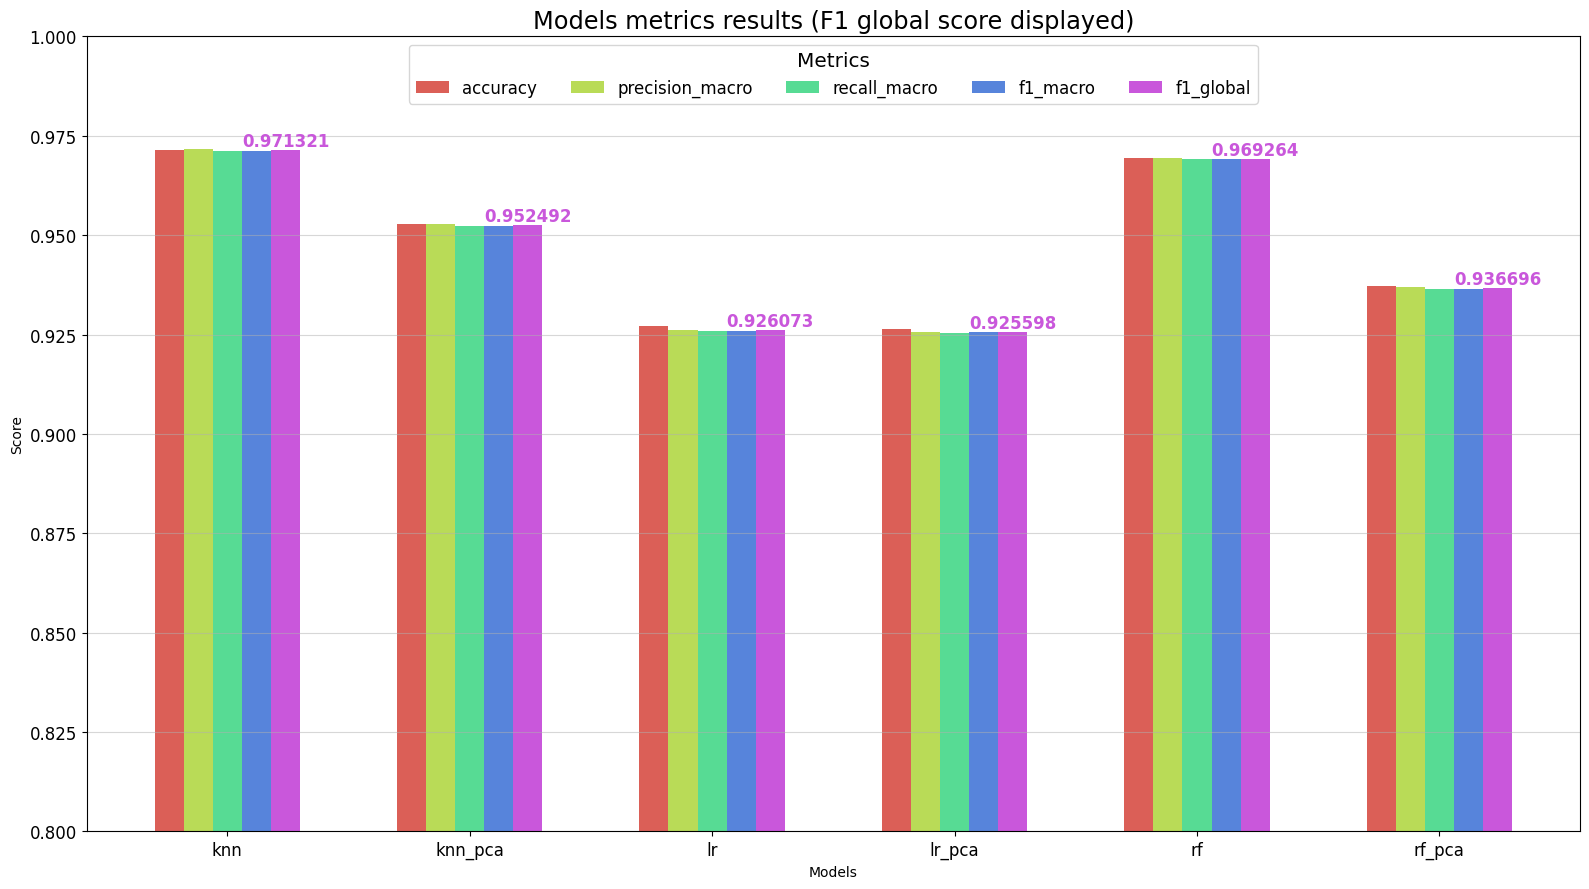

In [7]:
palette = sns.color_palette("hls", 5)
sns.set_palette(palette)

fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)

metrics = list(metrics_df.index)
x = np.arange(len(models_name))
width = 0.6 / 5

offsets = (np.arange(len(metrics)) - (len(metrics) - 1) / 2) * width

for metric, offset in zip(metrics, offsets):
    if metric=="f1_global":
        rects = ax.bar(x + offset, metrics_df.loc[metric], width, label=metric)
        ax.bar_label(rects, padding=0, fontweight="bold", color=palette[4], fontsize="large")
    else:
        ax.bar(x + offset, metrics_df.loc[metric], width, label=metric)

ax.set_title("Models metrics results (F1 global score displayed)", fontsize="xx-large")
ax.legend(loc="upper center", ncol=5, fontsize="large", title="Metrics", title_fontsize="x-large")
ax.set_ylim(0.8, 1)
ax.set_xticks(x, models_name, fontsize="large")
ax.grid(axis="y", alpha=0.5)
ax.set_xlabel("Models")
ax.set_ylabel("Score")
plt.setp(ax.get_yticklabels(), fontsize="large")

plt.show()

# Predictions similarity
Now we compute the prediction similarity among models in the following way:

$$
\text{similarity} = \dfrac{\text{images predicted in the same way}}{\text{total images}}.
$$

It is easy to compute similarity by using accuracy_score function.

NB: similarity increases also when two models predict wrong but in the same way.

In [8]:
similarity_matrix = np.eye(len(models_name))
for i in range(similarity_matrix.shape[0]):
    model_i = models_name[i]
    for j in range(similarity_matrix.shape[1]):
        model_j = models_name[j]
        similarity_value = round(accuracy_score(predictions_df[model_i], predictions_df[model_j]), 2)
        similarity_matrix[i, j] = similarity_value

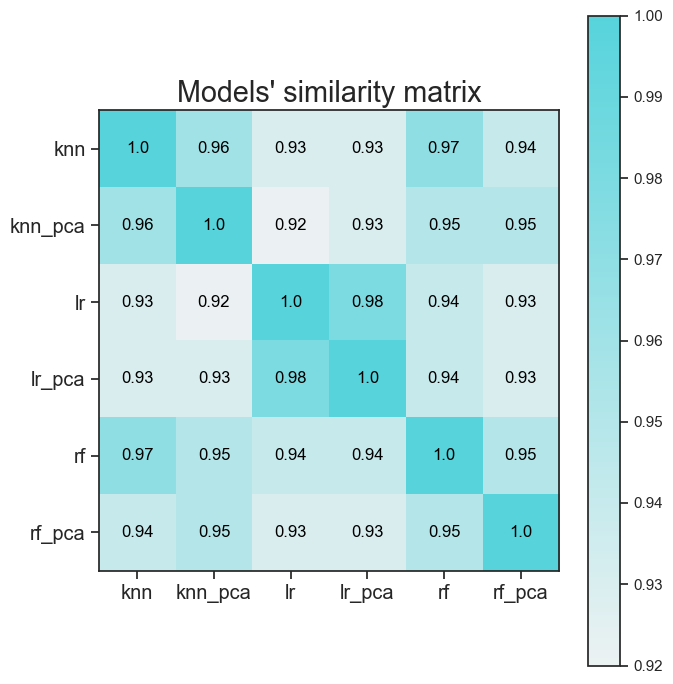

In [9]:
sns.set_theme(style="ticks")
cmap = sns.light_palette(color=sns.color_palette("hls", 2)[1], as_cmap=True)

fig, ax = plt.subplots(figsize=(7, 7), tight_layout=True)
im = ax.imshow(similarity_matrix, cmap=cmap)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(models_name)), models_name, fontsize="large")
ax.set_yticks(np.arange(len(models_name)), models_name, fontsize="large")
plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

# Add numbers
for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        text = ax.text(j, i, similarity_matrix[i, j], ha="center", va="center", color="black", fontsize="medium")
        
ax.set_title("Models' similarity matrix", fontsize="xx-large")

plt.show()

It's easy to see how models of the same family are more similar between each other.

# Confusion matrices
We will plot confusion matrix of each model.

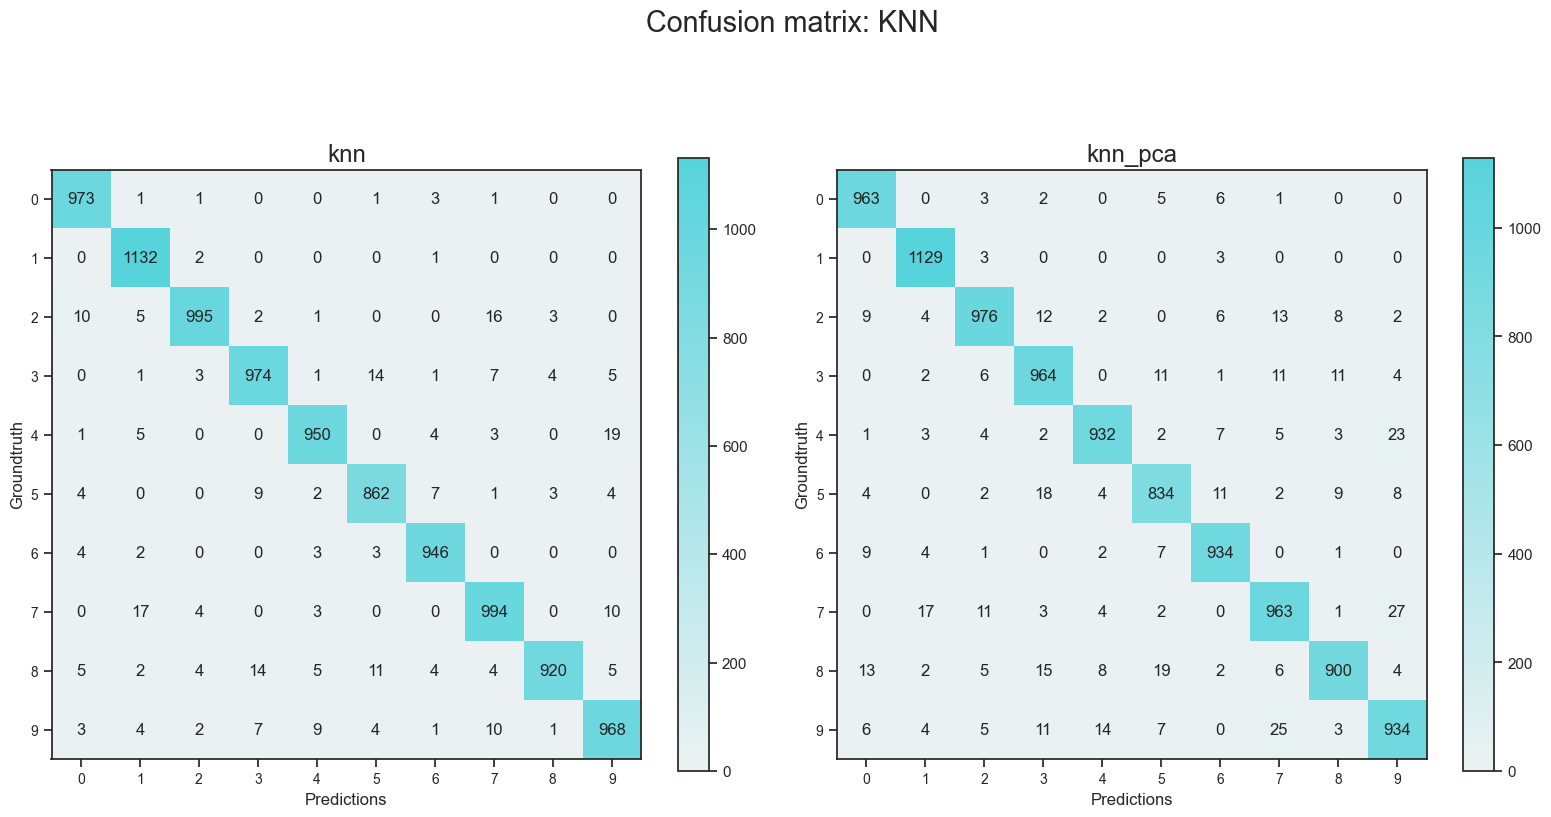

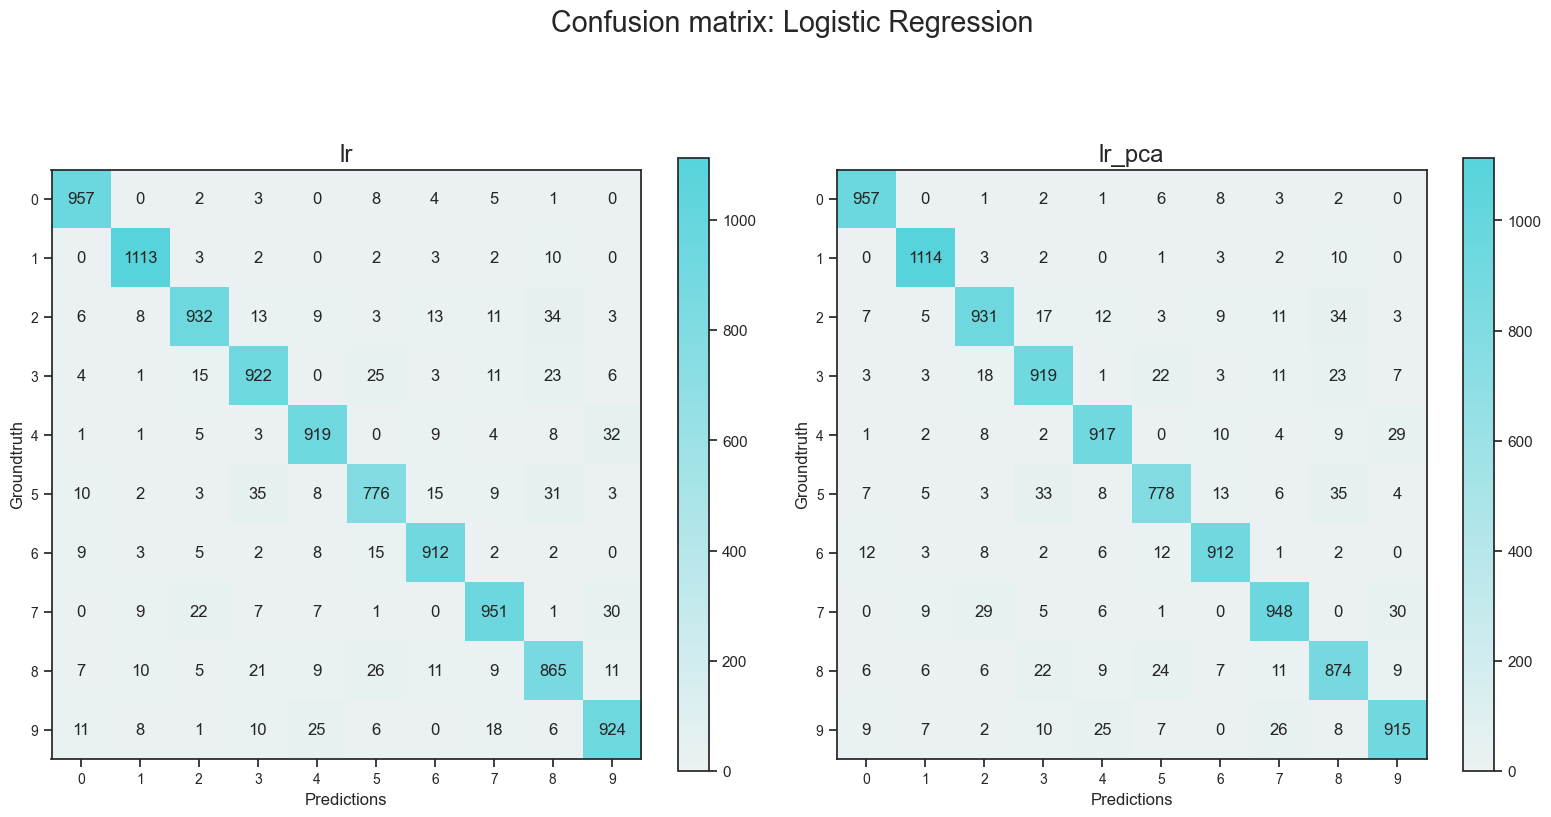

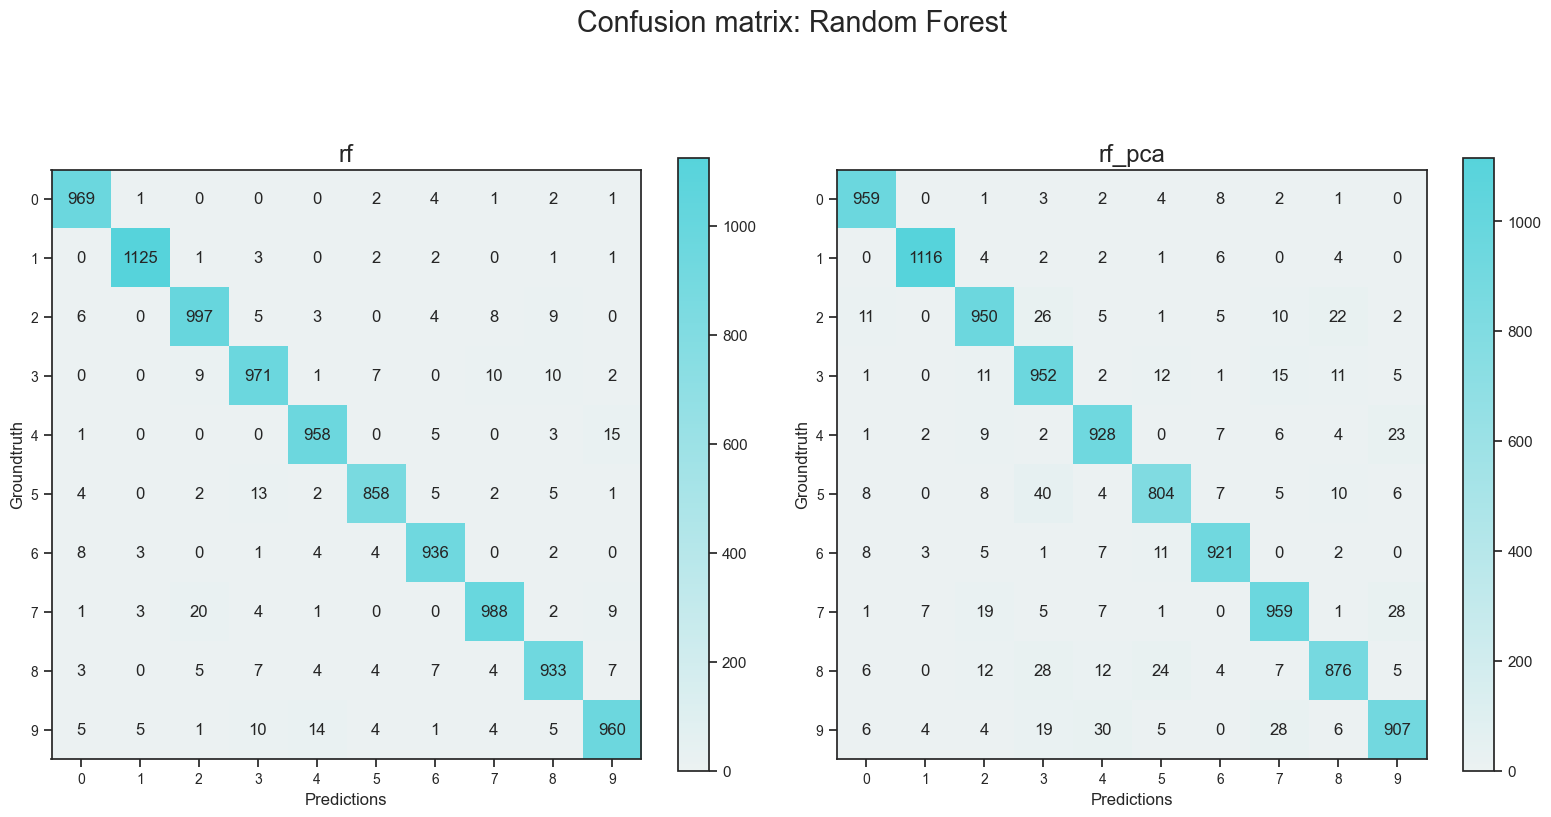

In [10]:
for models_list, title in zip([models_name[: 2], models_name[2: 4], models_name[4: ]],
                              ["KNN", "Logistic Regression", "Random Forest"]):

    categories = predictions_df["groundtruth"].unique()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), tight_layout=True)

    for ax, model in zip([ax1, ax2], models_list):
        ax.set_title(model, fontsize="x-large")
        cm = confusion_matrix(y_true=predictions_df["groundtruth"], y_pred=predictions_df[model])

        im = ax.imshow(cm, cmap=cmap)
        cbar = ax.figure.colorbar(im, ax=ax, shrink=0.75)

        ax.set_xticks(np.arange(len(categories)), categories, fontsize="small")
        ax.set_yticks(np.arange(len(categories)), categories, fontsize="small")
        ax.set_xlabel("Predictions", fontsize="medium")
        ax.set_ylabel("Groundtruth", fontsize="medium")
        #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Add numbers
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                text = ax.text(j, i, cm[i, j], ha="center", va="center", fontsize="medium")

    fig.suptitle("Confusion matrix: " + title, fontsize="xx-large")
plt.show()    

# Metrics for each category (label)

In [11]:
categories = list(predictions_df["groundtruth"].unique())
cat_dict = dict()
for category in categories:
    cat_index = categories.index(category)
    # Compute precision, recall and f1 score for every model
    m_dict = dict()
    for model in models_name:
        # Create confusion matrix
        cm = confusion_matrix(predictions_df["groundtruth"], predictions_df[model])
        TP = cm[cat_index, cat_index]
        FN_TP = cm[cat_index, :].sum()    # Sum of the row (in our case is always 1000)
        FP_TP = cm[:, cat_index].sum()    # Sum of the column
        precision = TP / FP_TP
        recall = TP / FN_TP
        f1_score = (2 * precision * recall) / (precision + recall)
        m_dict[model] = {"precision": precision, "recall": recall, "f1_score": f1_score}
    cat_dict[category] = m_dict

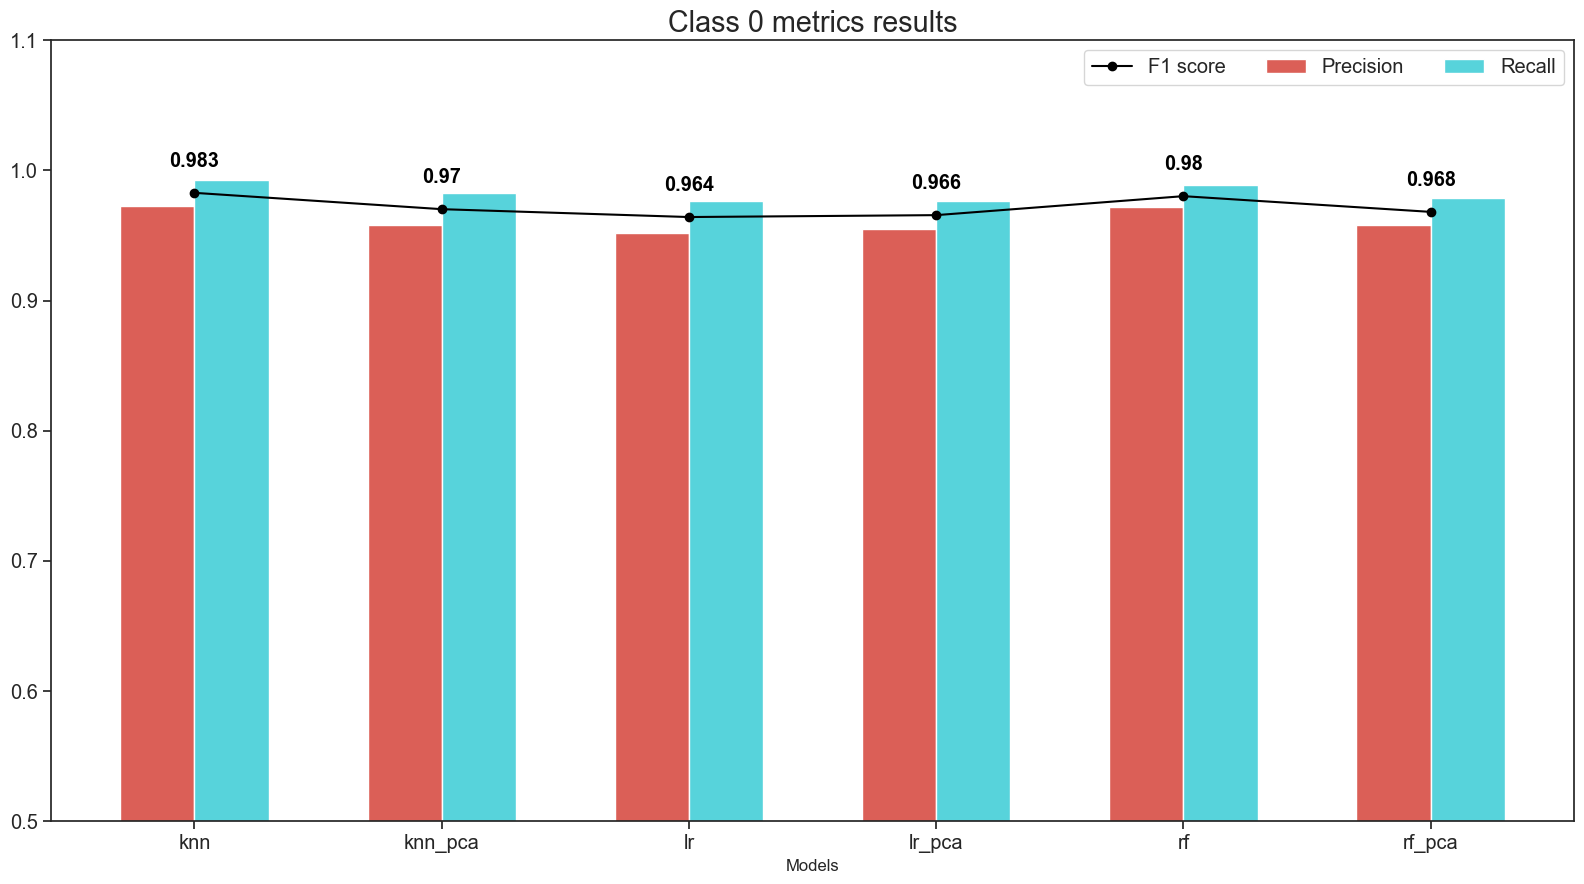

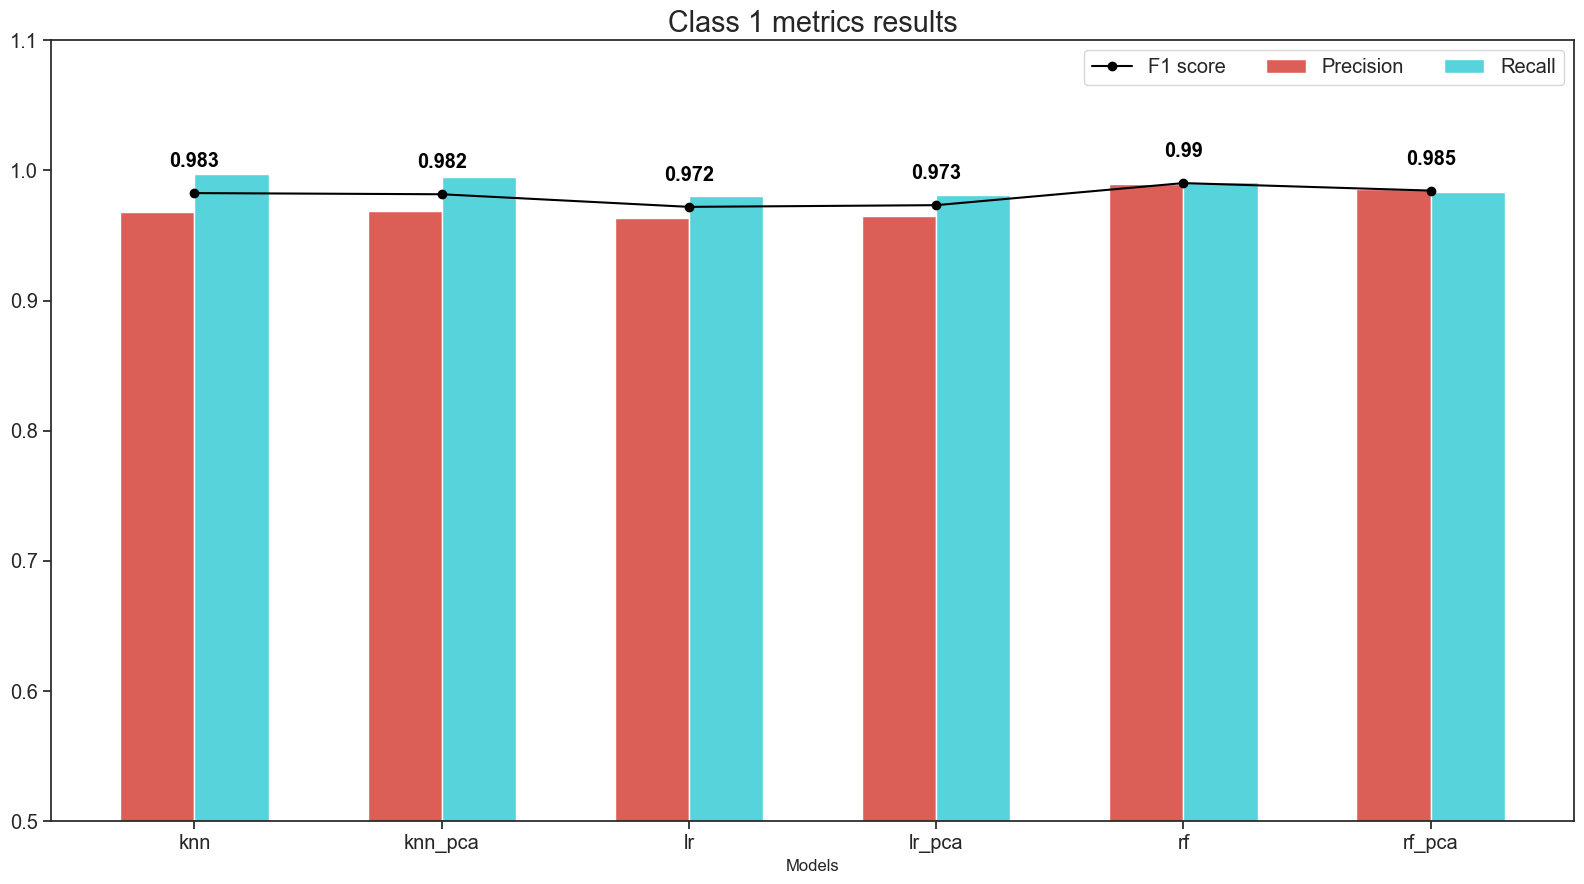

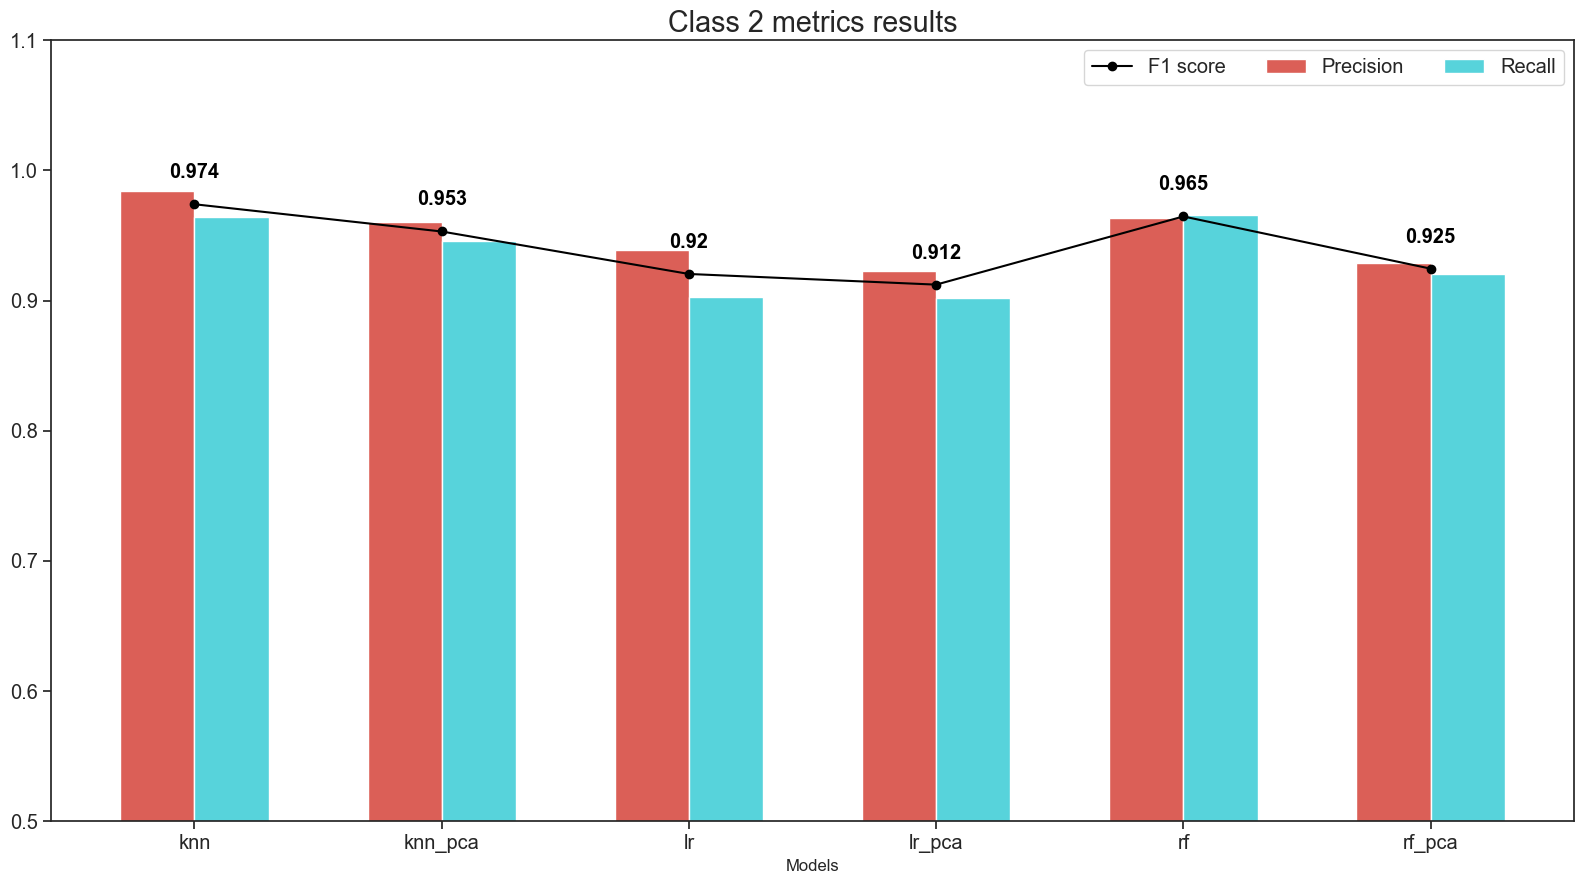

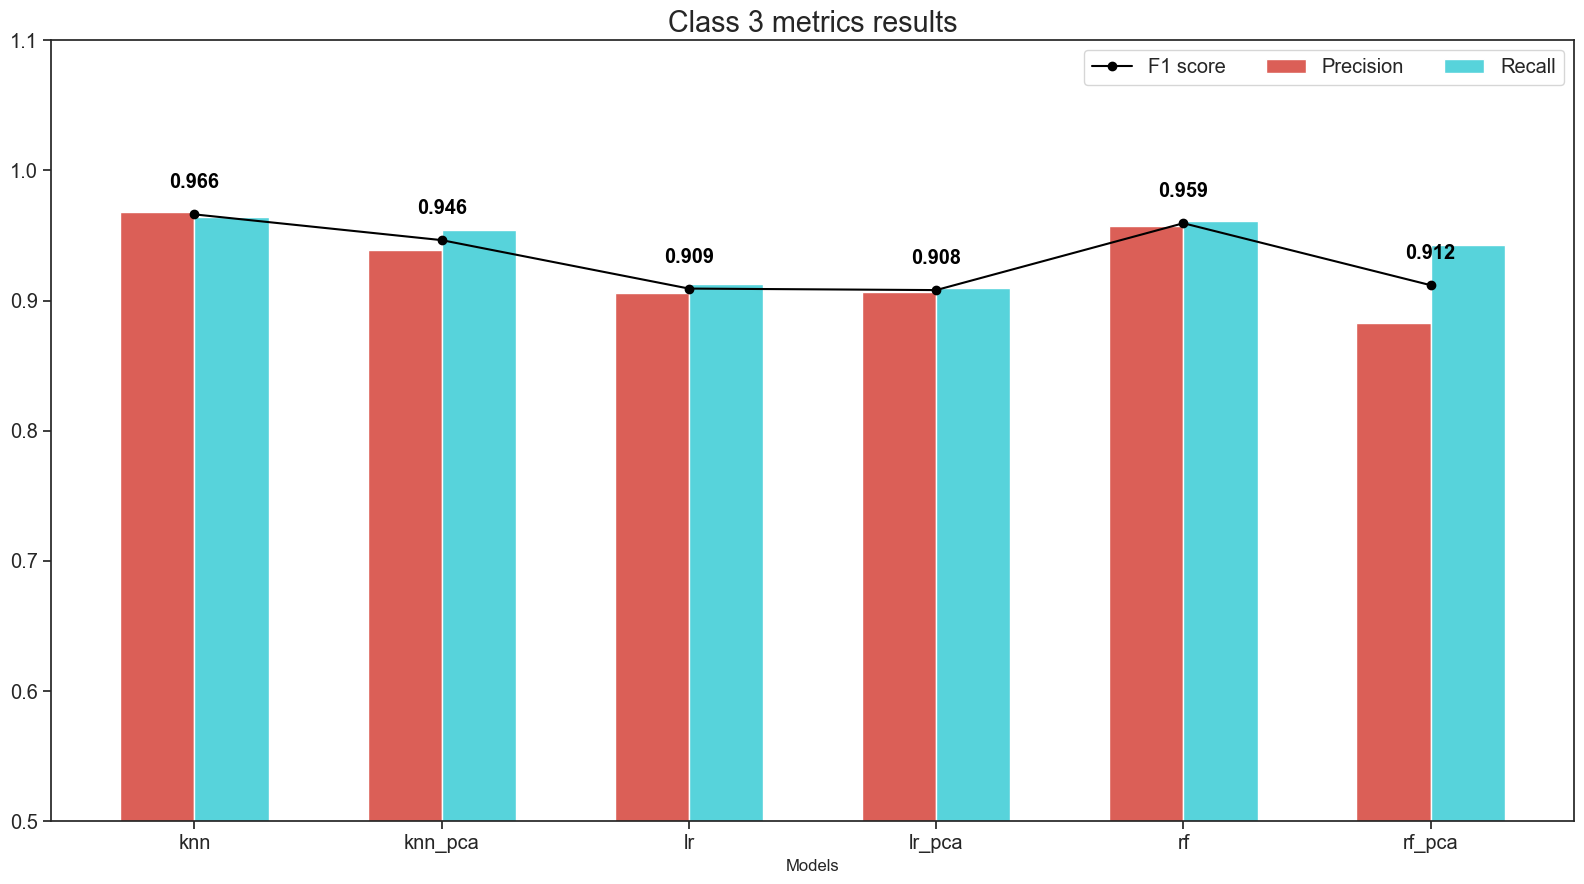

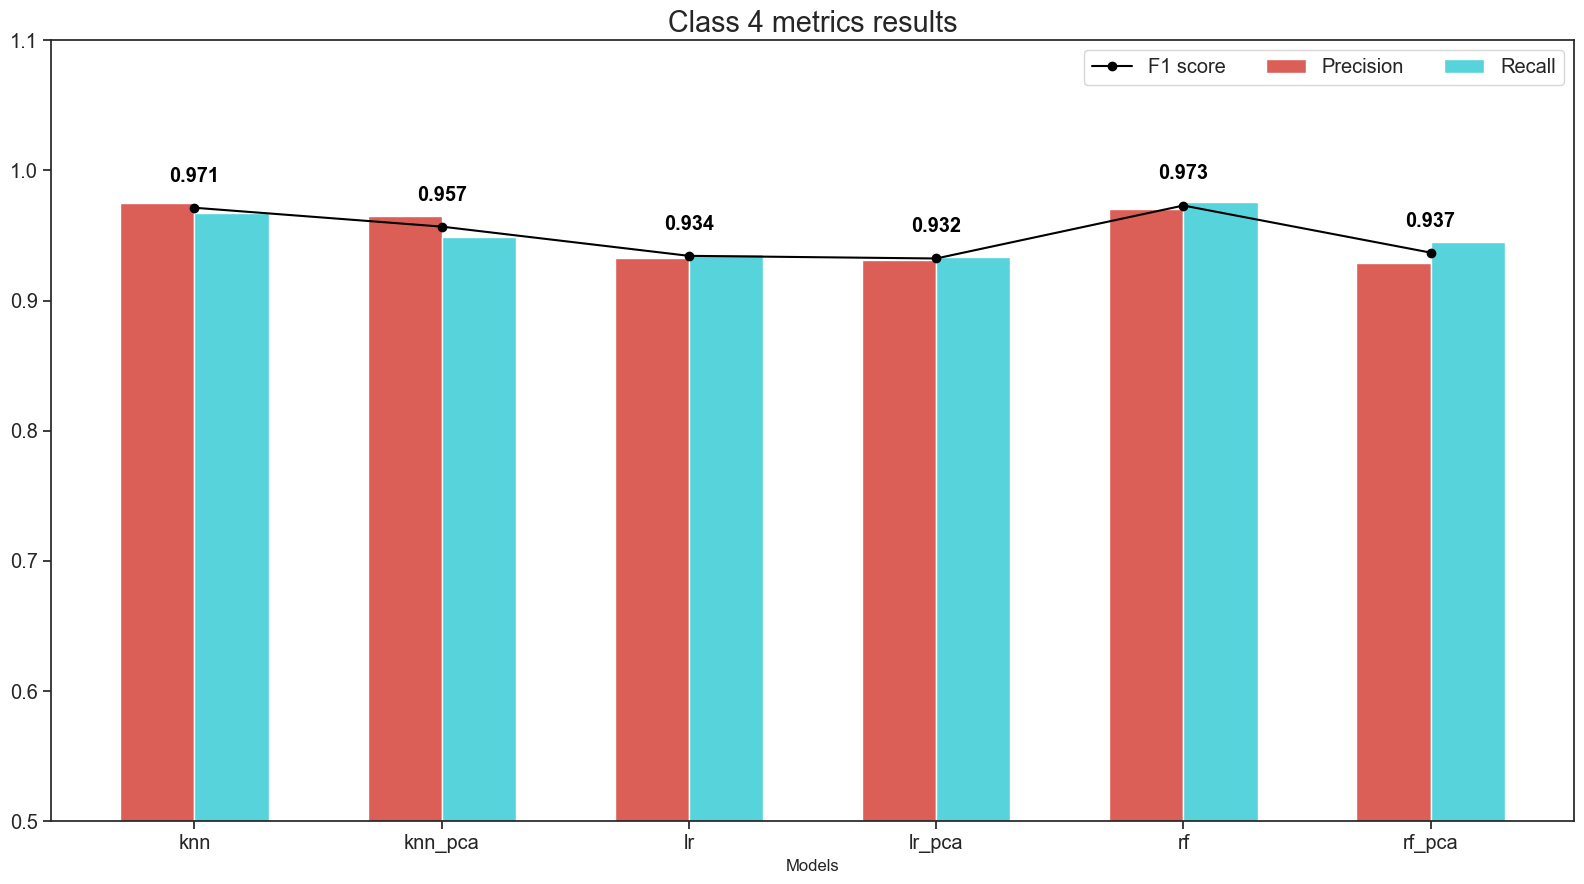

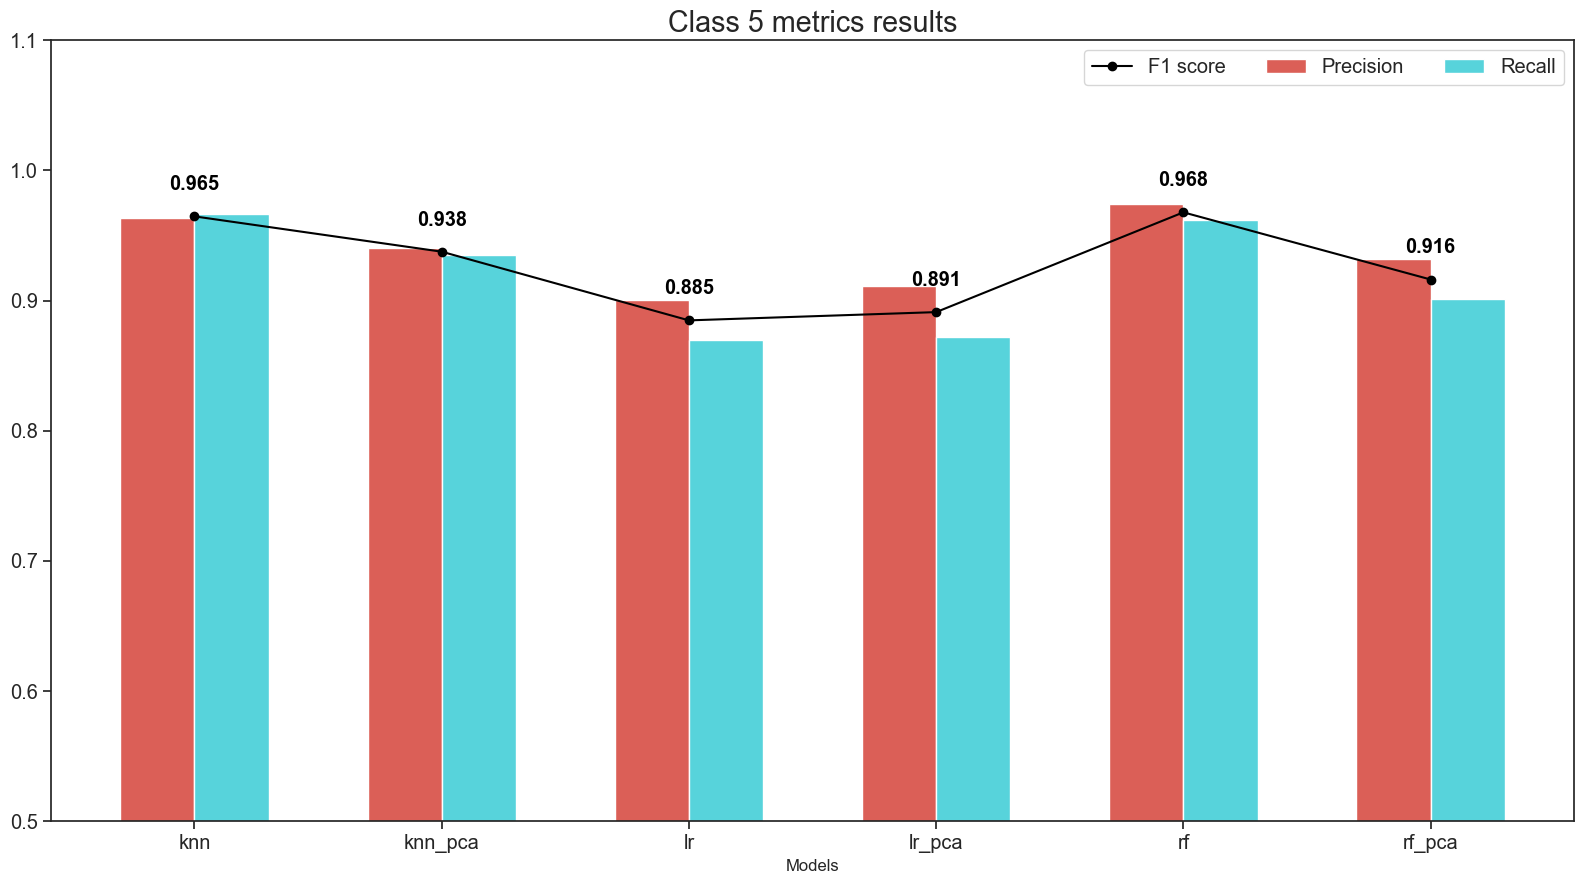

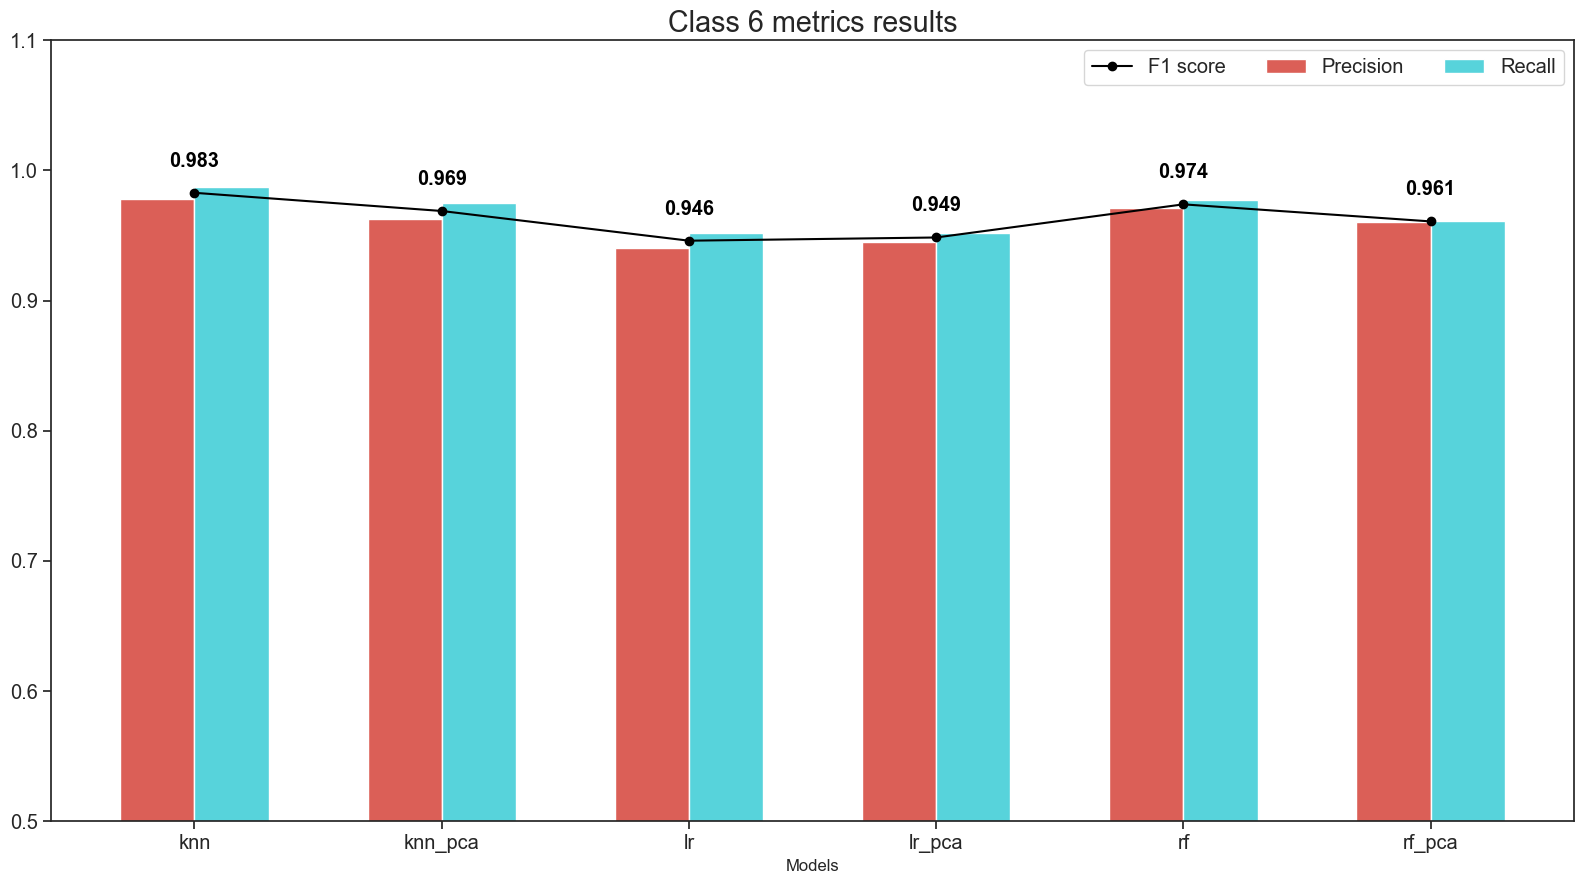

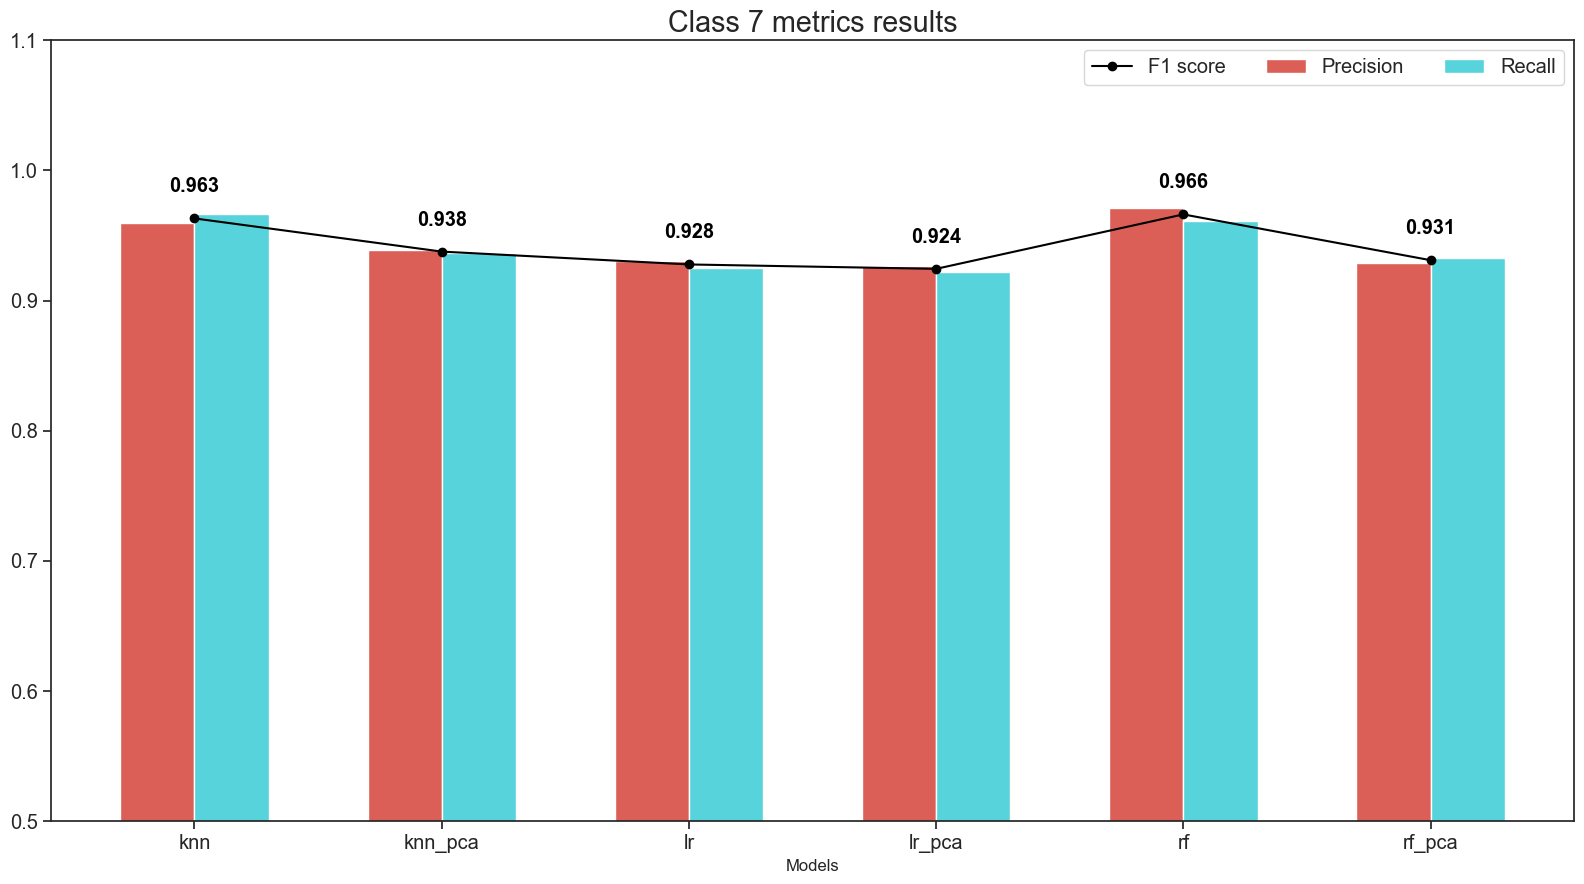

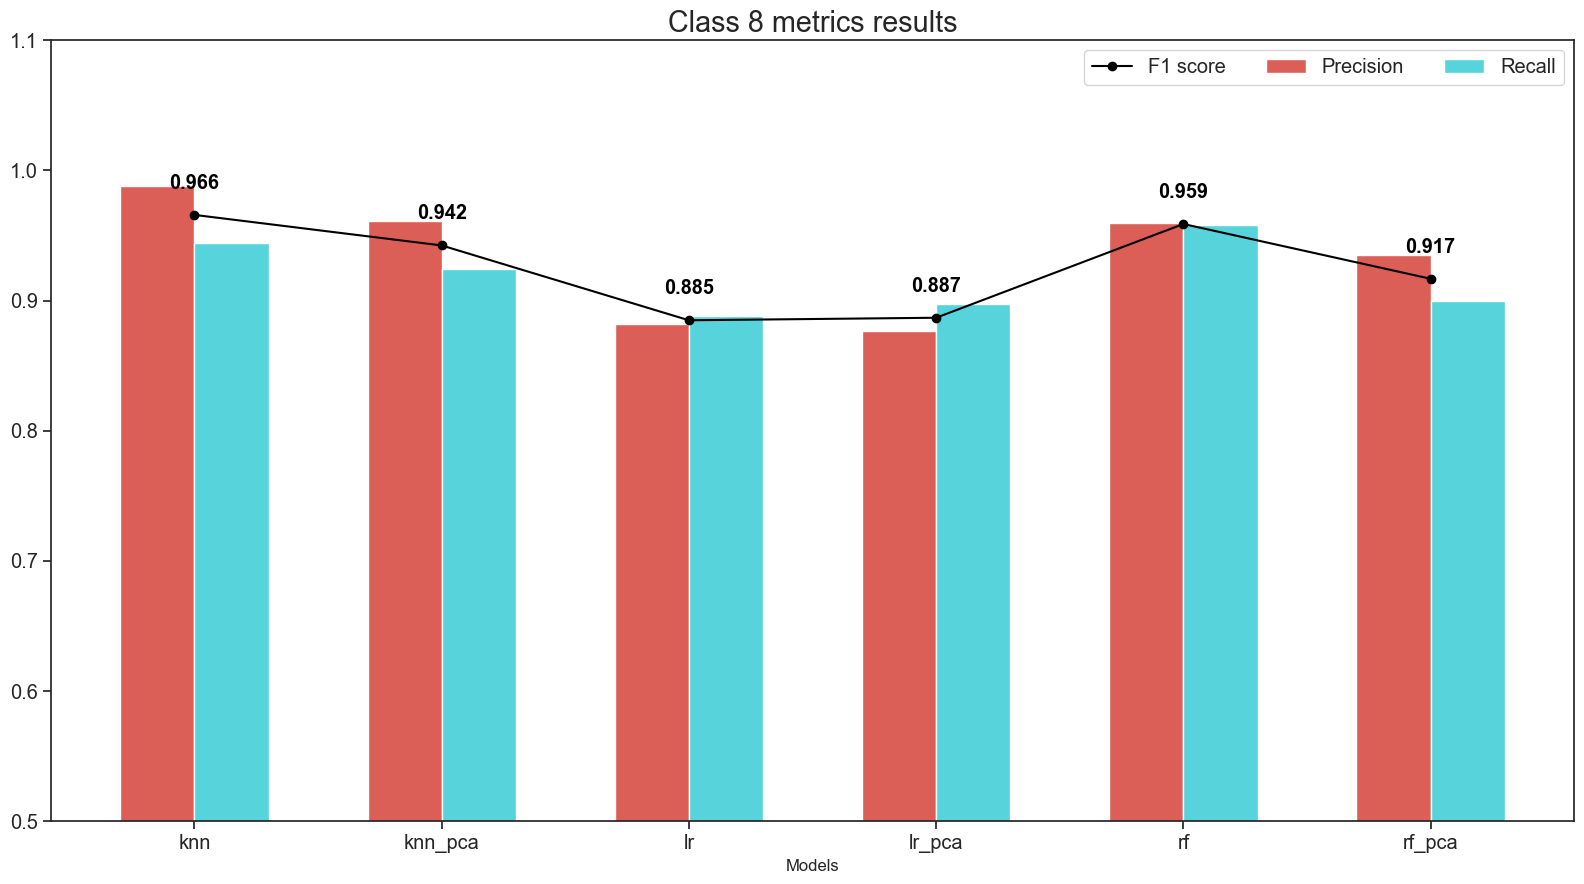

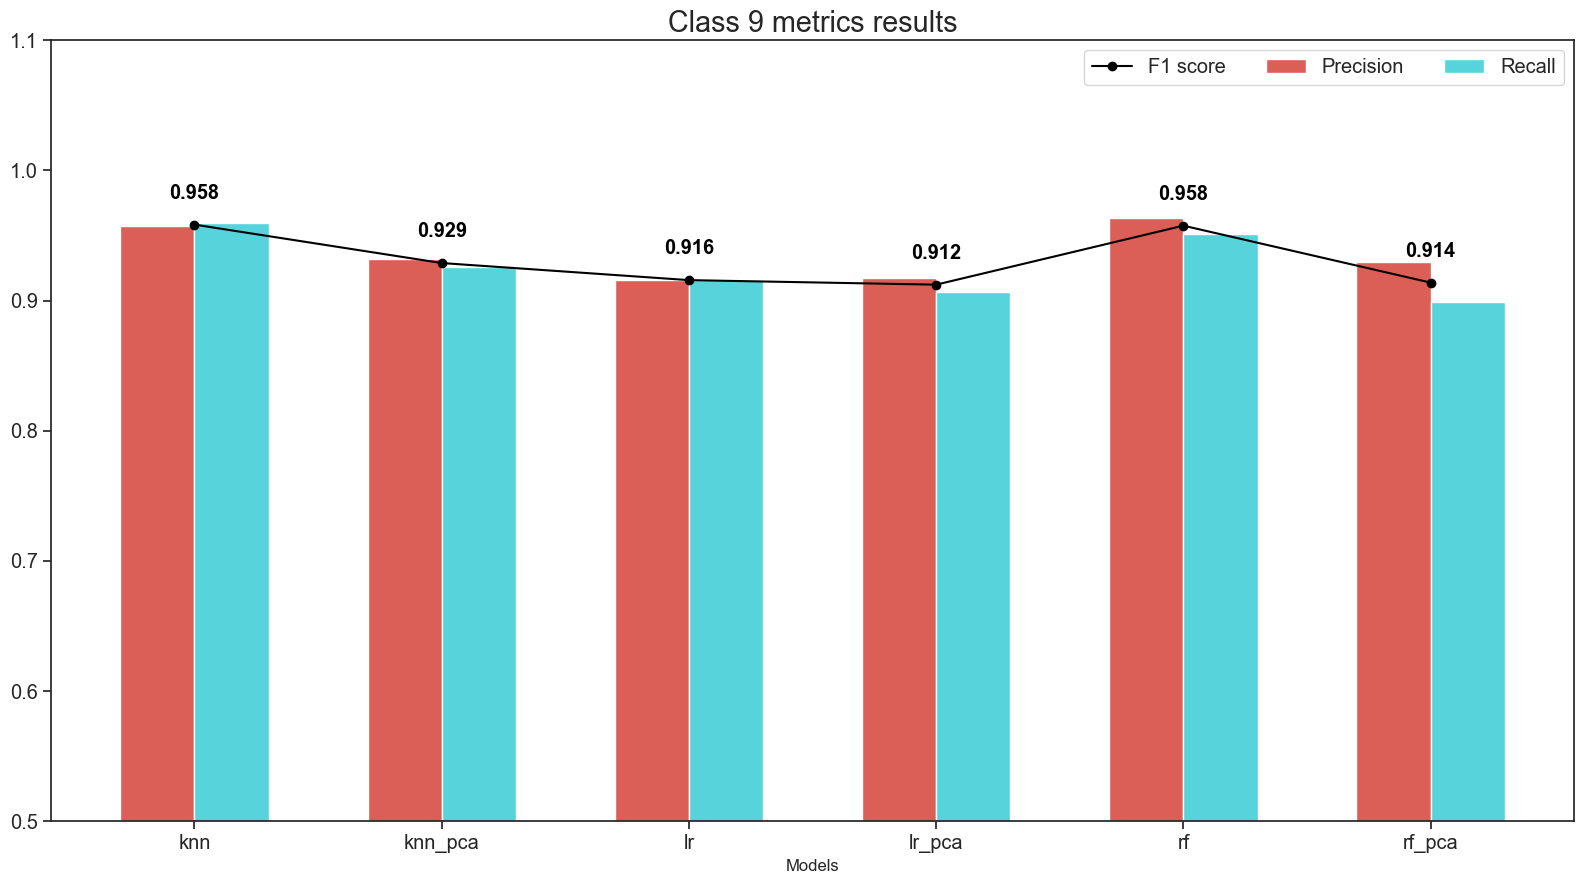

In [12]:
#sns.set_style("whitegrid")
palette = sns.color_palette("hls", 2)
sns.set_palette(palette)

x = np.arange(len(models_name))
width = 0.3
offset = width/2

for category in cat_dict.keys():
    fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)

    precision_values = [cat_dict[category][model]["precision"] for model in models_name]
    recall_values = [cat_dict[category][model]["recall"] for model in models_name]
    f1_score_values = [cat_dict[category][model]["f1_score"] for model in models_name]

    ax.bar(x-offset, precision_values, label="Precision", width=width)
    #ax.bar(x, f1_score_values, label="F1 score", width=width)
    ax.bar(x+offset, recall_values, label="Recall", width=width)
    ax.plot(f1_score_values, color="black", marker="o", label="F1 score")

    for xx, ff in zip(x, f1_score_values):
        ax.text(xx, ff+0.02, str(round(ff, 3)), ha="center", color="black", fontweight="bold", fontsize="large")

    ax.set_title("Class " + str(category).title() + " metrics results", fontsize="xx-large")
    ax.set_xticks(x, models_name, fontsize="large")
    ax.legend(ncol=3, fontsize="large", title_fontsize="x-large")
    ax.set_ylim(0.5, 1.1)
    ax.set_xlabel("Models")
    plt.setp(ax.get_yticklabels(), fontsize="large")

plt.show()

# Speed comparison
Each sample is composed with 100 images of shape 28 x 28.

In [13]:
N = 100    # Number of images in each sample
time_df = pd.read_csv("time_mnist.csv", index_col=0)
display(time_df)

,knn,knn_pca,lr,lr_pca,rf,rf_pca
sample 1,2.783082,1.382622,0.018133,0.123507,4.644084,4.673895
sample 2,2.811573,1.445557,0.015620,0.063009,4.551475,4.708474
sample 3,2.764334,1.480147,0.031262,0.062979,4.280191,4.756178
sample 4,2.749163,1.399418,0.015619,0.063238,4.673317,4.757974
sample 5,2.810524,1.397744,0.027563,0.066532,4.660843,4.689234
...,...,...,...,...,...,...
sample 96,2.813272,1.603994,0.012527,0.062515,4.518001,4.452278
sample 97,2.625368,1.366662,0.015637,0.074013,4.601452,4.140303
sample 98,2.764961,1.298680,0.006514,0.063061,4.207790,4.597936
sample 99,2.763372,1.428569,0.015604,0.078522,4.723933,4.581455


In [14]:
# Summary statistics
display(time_df.describe())

,knn,knn_pca,lr,lr_pca,rf,rf_pca
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.778346,1.446664,0.018084,0.081491,4.560799,4.626379
std,0.070370,0.130418,0.009734,0.022013,0.126534,0.166163
min,2.319769,1.170615,0.000000,0.046883,4.062191,3.689269
25%,2.753304,1.362557,0.015615,0.062893,4.521854,4.599152
50%,2.780370,1.426738,0.015642,0.078521,4.586543,4.661839
75%,2.810606,1.544237,0.027492,0.095410,4.628301,4.706928
max,2.939507,1.806010,0.043232,0.125650,4.867960,4.926862


# Single image statistics

In [15]:
mean_time_single_image = time_df.describe().loc["mean"] / N
print(mean_time_single_image)

knn        0.027783
knn_pca    0.014467
lr         0.000181
lr_pca     0.000815
rf         0.045608
rf_pca     0.046264
Name: mean, dtype: float64


In [16]:
std_time_single_image = time_df.describe().loc["std"] / np.sqrt(N)
print(std_time_single_image)

knn        0.007037
knn_pca    0.013042
lr         0.000973
lr_pca     0.002201
rf         0.012653
rf_pca     0.016616
Name: std, dtype: float64


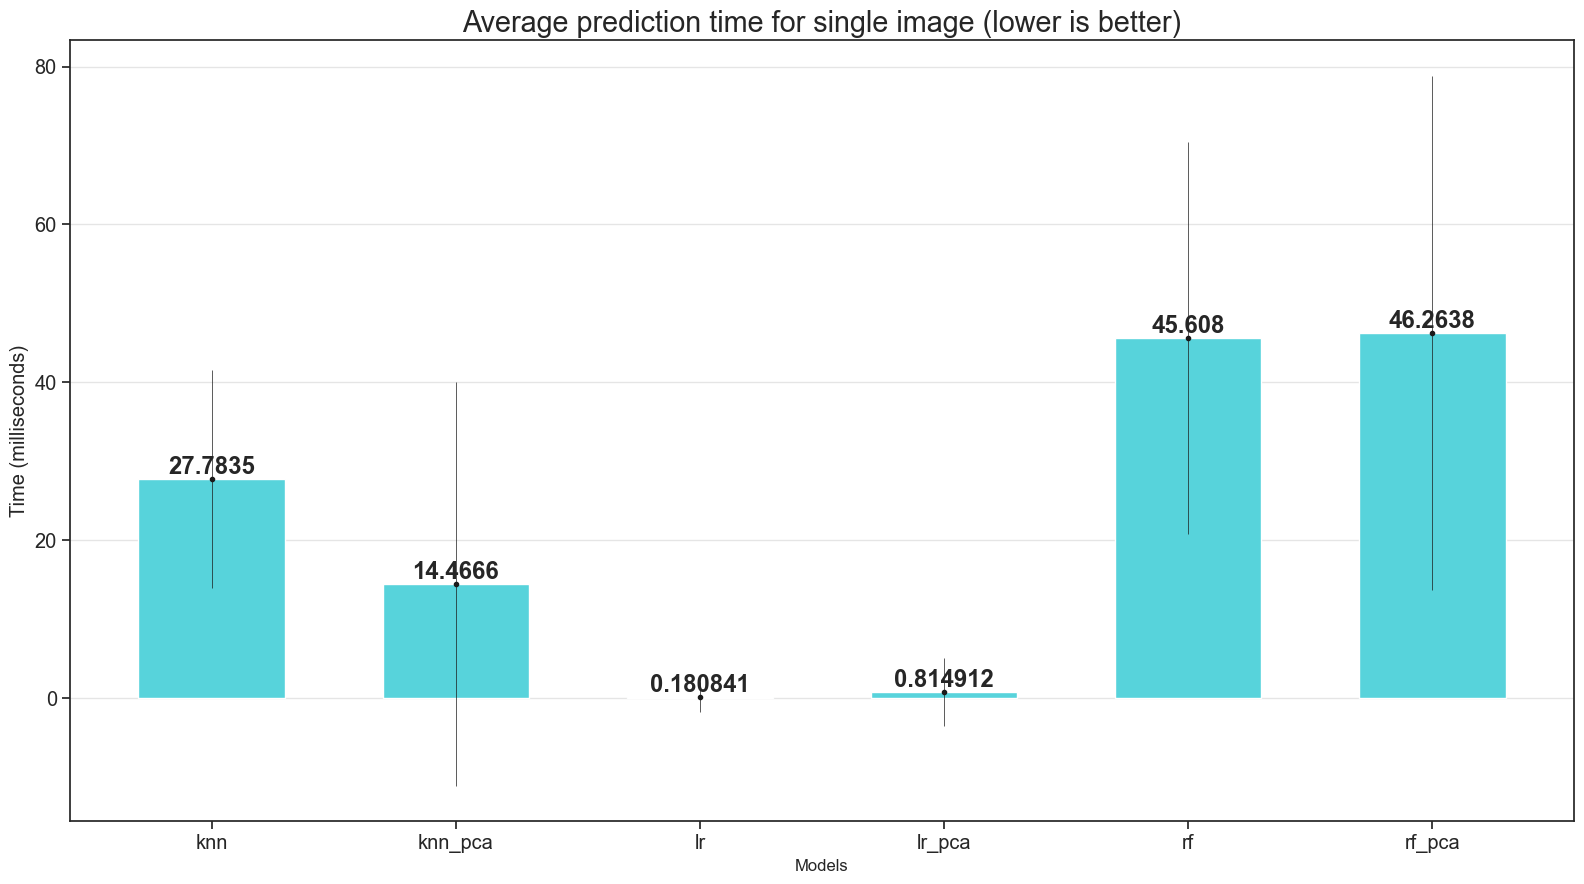

In [17]:
palette = sns.color_palette("hls", 2)
sns.set_palette(palette)

fig, ax = plt.subplots(figsize=(16, 9), tight_layout = True)

x = np.arange(len(time_df.columns))

rects = ax.bar(x, mean_time_single_image*1000, width=0.6, color=palette[1])
ax.bar_label(rects, fontsize="x-large", fontweight="bold")
ax.errorbar(x, mean_time_single_image*1000, yerr=1.96*std_time_single_image*1000, fmt=".k", elinewidth=0.5)

ax.set_ylabel("Time (milliseconds)", fontsize="large")
ax.set_xlabel("Models")
ax.set_xticks(x, list(time_df.columns), fontsize="large")
ax.grid(axis="y", alpha=0.5)
ax.set_title("Average prediction time for single image (lower is better)", fontsize="xx-large")

plt.setp(ax.get_yticklabels(), fontsize="large")

plt.show()